In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [280]:
def scatter_plots(x_col, y_cols, df):
    num_plots = len(y_cols)
    num_rows = (num_plots + 3) // 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    axes = axes.flatten()

    for i, y_col in enumerate(y_cols):
        sns.scatterplot(x=x_col, y=y_col, data=df, ax=axes[i])
        axes[i].set_title(f'{x_col} vs {y_col}')
        axes[i].set_xlabel(x_col)
        axes[i].set_ylabel(y_col)
        axes[i].grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def scatter_plot(x_col, y_col, df):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=x_col, y=y_col, data=df)
    plt.title(f'{x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.show()

def get_null_percentage(column_name, df):
    null_percentage = df[column_name].isnull().sum() / len(df) * 100
    display(f"Null percentage for {column_name}: {null_percentage:.2f}")

def hist_plots(df, cols):
    plt.figure(figsize=(20, 70))
    for i, col in enumerate(cols):
        plt.subplot(25, 5, i + 1)
        sns.histplot(df[col], kde=True)
        plt.xlabel(col)
        plt.title(col)
        plt.grid(True)
        plt.tight_layout()
    plt.show()

def hist_plot(col, df):
    plt.figure(figsize=(8, 8))
    sns.histplot(df[col], kde=True)
    plt.xlabel(col)
    plt.title(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def box_plots(df, cols):
    plt.figure(figsize=(20, 70))
    for i, col in enumerate(cols):
        plt.subplot(25, 5, i + 1)
        sns.boxplot(y=df[col])
        plt.title(col)
        plt.tight_layout()
    plt.show()

def box_plot(col, df):
    plt.figure(figsize=(8, 8))
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()
    plt.show()

In [281]:
train_df = pd.read_csv('train.csv')

In [282]:
display(train_df.columns)

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [283]:
# As sii column is calculated from PCIAT Total and that is calculated from PCIAT questions, we can drop all PCIAT columns. We will only keep the season column
columns_to_drop = train_df.filter(regex='^PCIAT').columns.difference(['PCIAT-Season'])
train_df.drop(columns=columns_to_drop, inplace=True)

In [284]:
high_null_columns = train_df.columns[train_df.isnull().mean() > 0.5]
print("Columns with more than 50% null values:")
display(high_null_columns)


Columns with more than 50% null values:


Index(['Physical-Waist_Circumference', 'Fitness_Endurance-Season',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone',
       'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total',
       'PAQ_C-Season', 'PAQ_C-PAQ_C_Total'],
      dtype='object')

In [285]:
# Converting seasons to numeric values
def convert_season_to_numeric(season):
    season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
    return season_mapping.get(season, season)

train_df.update(train_df.filter(regex='Season$').applymap(convert_season_to_numeric))

In [286]:
# Knowing that BMI is calculated from weight and height we can get rid of those two columns
train_df.drop(columns=['Physical-Weight', 'Physical-Height'], inplace=True)

In [287]:
get_null_percentage('BIA-BIA_BMI', train_df)
get_null_percentage('Physical-BMI', train_df)

'Null percentage for BIA-BIA_BMI: 49.72'

'Null percentage for Physical-BMI: 23.69'

In [288]:
# We will see what are the average difference between BIA-BIA_BMI and Physical-BMI and possibly use one of them to fill the missing values in the other column
valid_rows = train_df.dropna(subset=['BIA-BIA_BMI', 'Physical-BMI'])
difference = valid_rows['BIA-BIA_BMI'] - valid_rows['Physical-BMI']
average_difference = difference.mean()

print(f"Average difference: {average_difference}")

Average difference: 0.008277280229832533


In [289]:
train_df['Physical-BMI'] = train_df['Physical-BMI'].fillna(train_df['BIA-BIA_BMI'])

In [290]:
# To not create bias in data we will drop them
train_df.drop(columns=high_null_columns, inplace=True)

In [291]:
get_null_percentage('Physical-BMI', train_df)

'Null percentage for Physical-BMI: 23.18'

In [292]:
# That did not make a huge difference so we will drop one of the columns and will the value in a different way
train_df.drop(columns=['BIA-BIA_BMI'], inplace=True)

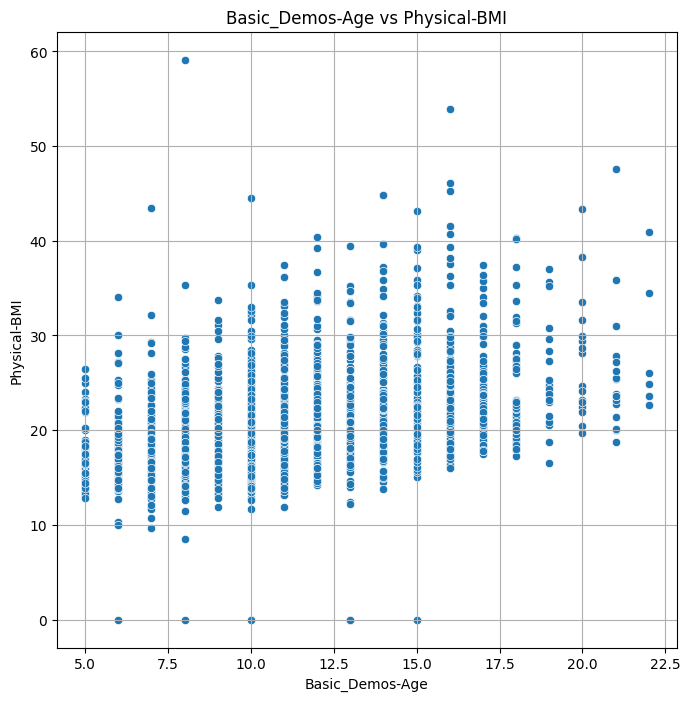

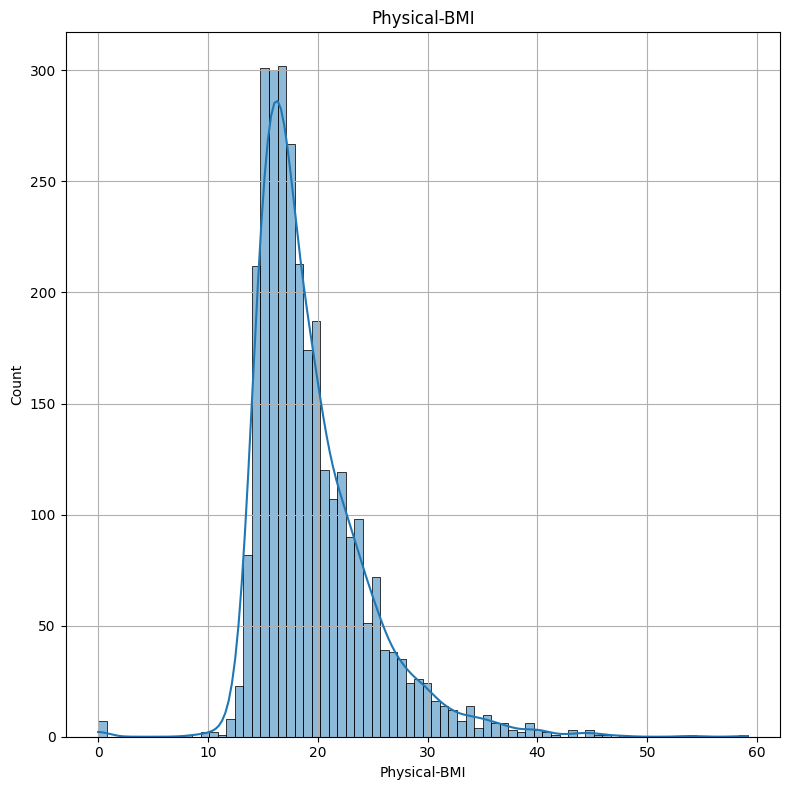

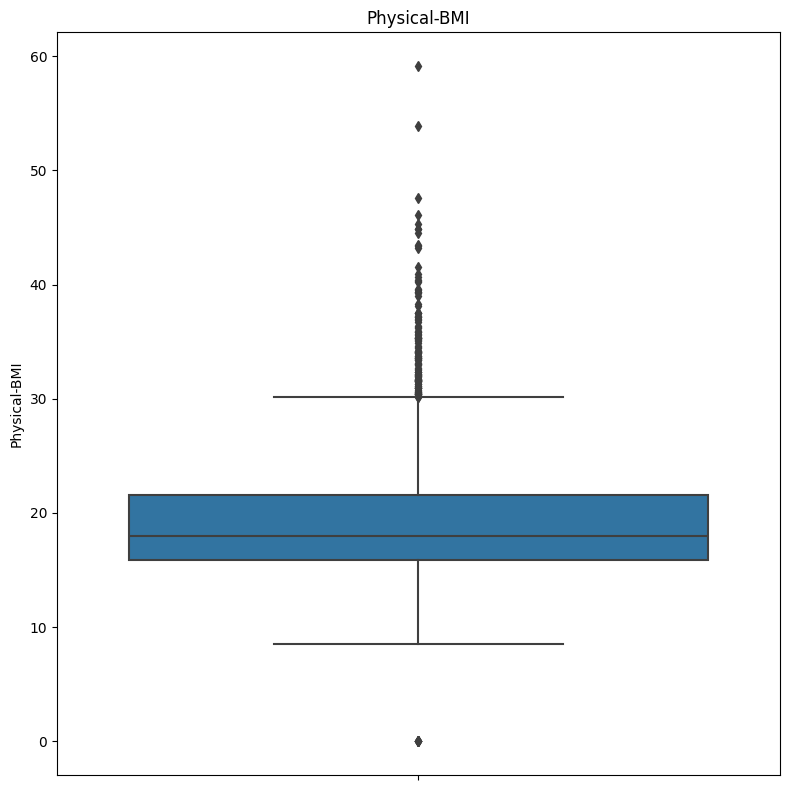

In [293]:
scatter_plot('Basic_Demos-Age', 'Physical-BMI', train_df)
hist_plot('Physical-BMI', train_df)
box_plot('Physical-BMI', train_df)


In [294]:
# Seeing as the data has a right skewed bell curve and the data is close together, we can use the median or average value to fill the missing values
Q1 = train_df['Physical-BMI'].quantile(0.25)
Q3 = train_df['Physical-BMI'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_bmi = train_df[(train_df['Physical-BMI'] >= lower_bound) & (train_df['Physical-BMI'] <= upper_bound)]['Physical-BMI']

adjusted_bmi = np.log(filtered_bmi)

average_bmi = adjusted_bmi.mean()
median_bmi = adjusted_bmi.median()

print(f"Average BMI (log-transformed): {average_bmi}")
print(f"Median BMI (log-transformed): {median_bmi}")

Average BMI (log-transformed): 2.9105432836592926
Median BMI (log-transformed): 2.8753845074739646


In [295]:
# We ill be using the average value to fill the missing values by first apply log on the current columns and then filling the missing values
train_df['Physical-BMI'] = np.log(train_df['Physical-BMI'])
train_df['Physical-BMI'].fillna(average_bmi, inplace=True)

/Users/asilins/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


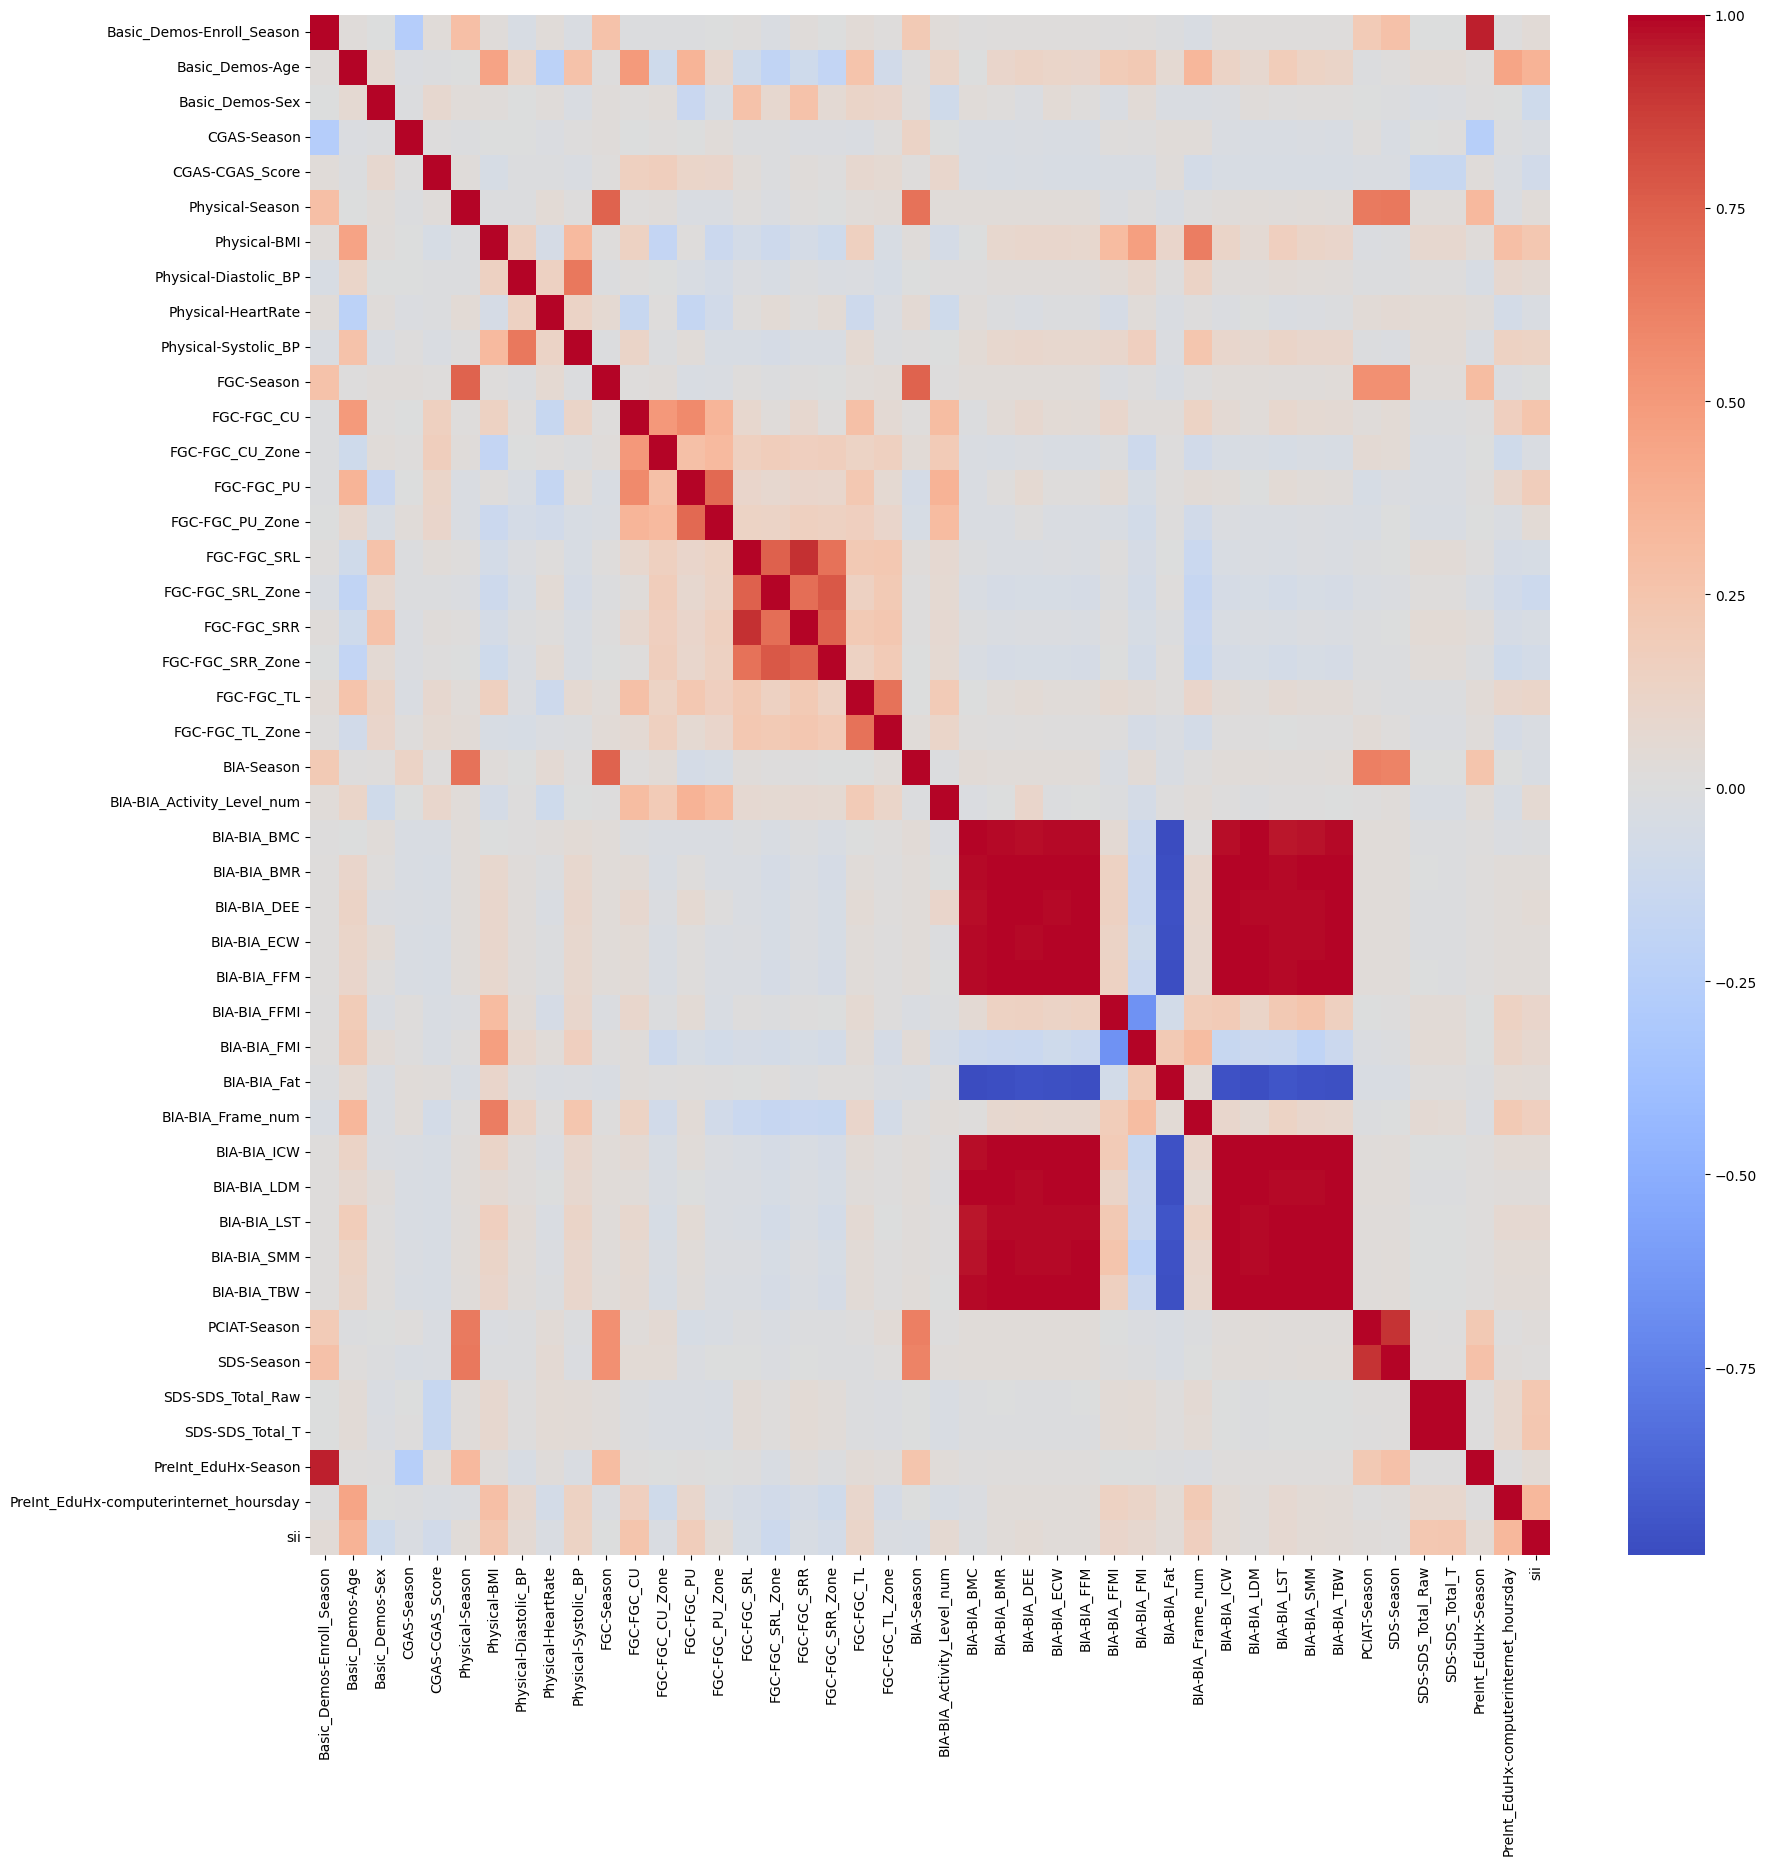

In [296]:
# Lets look at a correlation matrix to see if there are any columns that are highly correlated to see if we can get rid of them
temp = train_df.copy()
temp.drop(['id'], axis=1, inplace=True)
correlation_matrix = temp.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

In [297]:
# Seeing that many columns in BIA are highly correlated, we will look if we can drop them
bia_df = train_df.filter(regex='^BIA')
null_percentage = bia_df.isnull().sum() / len(bia_df) * 100
display(null_percentage)

BIA-Season                    45.833333
BIA-BIA_Activity_Level_num    49.722222
BIA-BIA_BMC                   49.722222
BIA-BIA_BMR                   49.722222
BIA-BIA_DEE                   49.722222
BIA-BIA_ECW                   49.722222
BIA-BIA_FFM                   49.722222
BIA-BIA_FFMI                  49.722222
BIA-BIA_FMI                   49.722222
BIA-BIA_Fat                   49.722222
BIA-BIA_Frame_num             49.722222
BIA-BIA_ICW                   49.722222
BIA-BIA_LDM                   49.722222
BIA-BIA_LST                   49.722222
BIA-BIA_SMM                   49.722222
BIA-BIA_TBW                   49.722222
dtype: float64

In [298]:
# As the null percentage is around 50%, we can drop the columns as we can assume the corelation is not from missing values
bia_corr_matrix = train_df.filter(regex='^BIA').corr()

high_corr_threshold = 0.9
high_corr_pairs = bia_corr_matrix.columns[
    (bia_corr_matrix.abs() > high_corr_threshold).sum() > 1
]

train_df.drop(columns=high_corr_pairs, inplace=True)


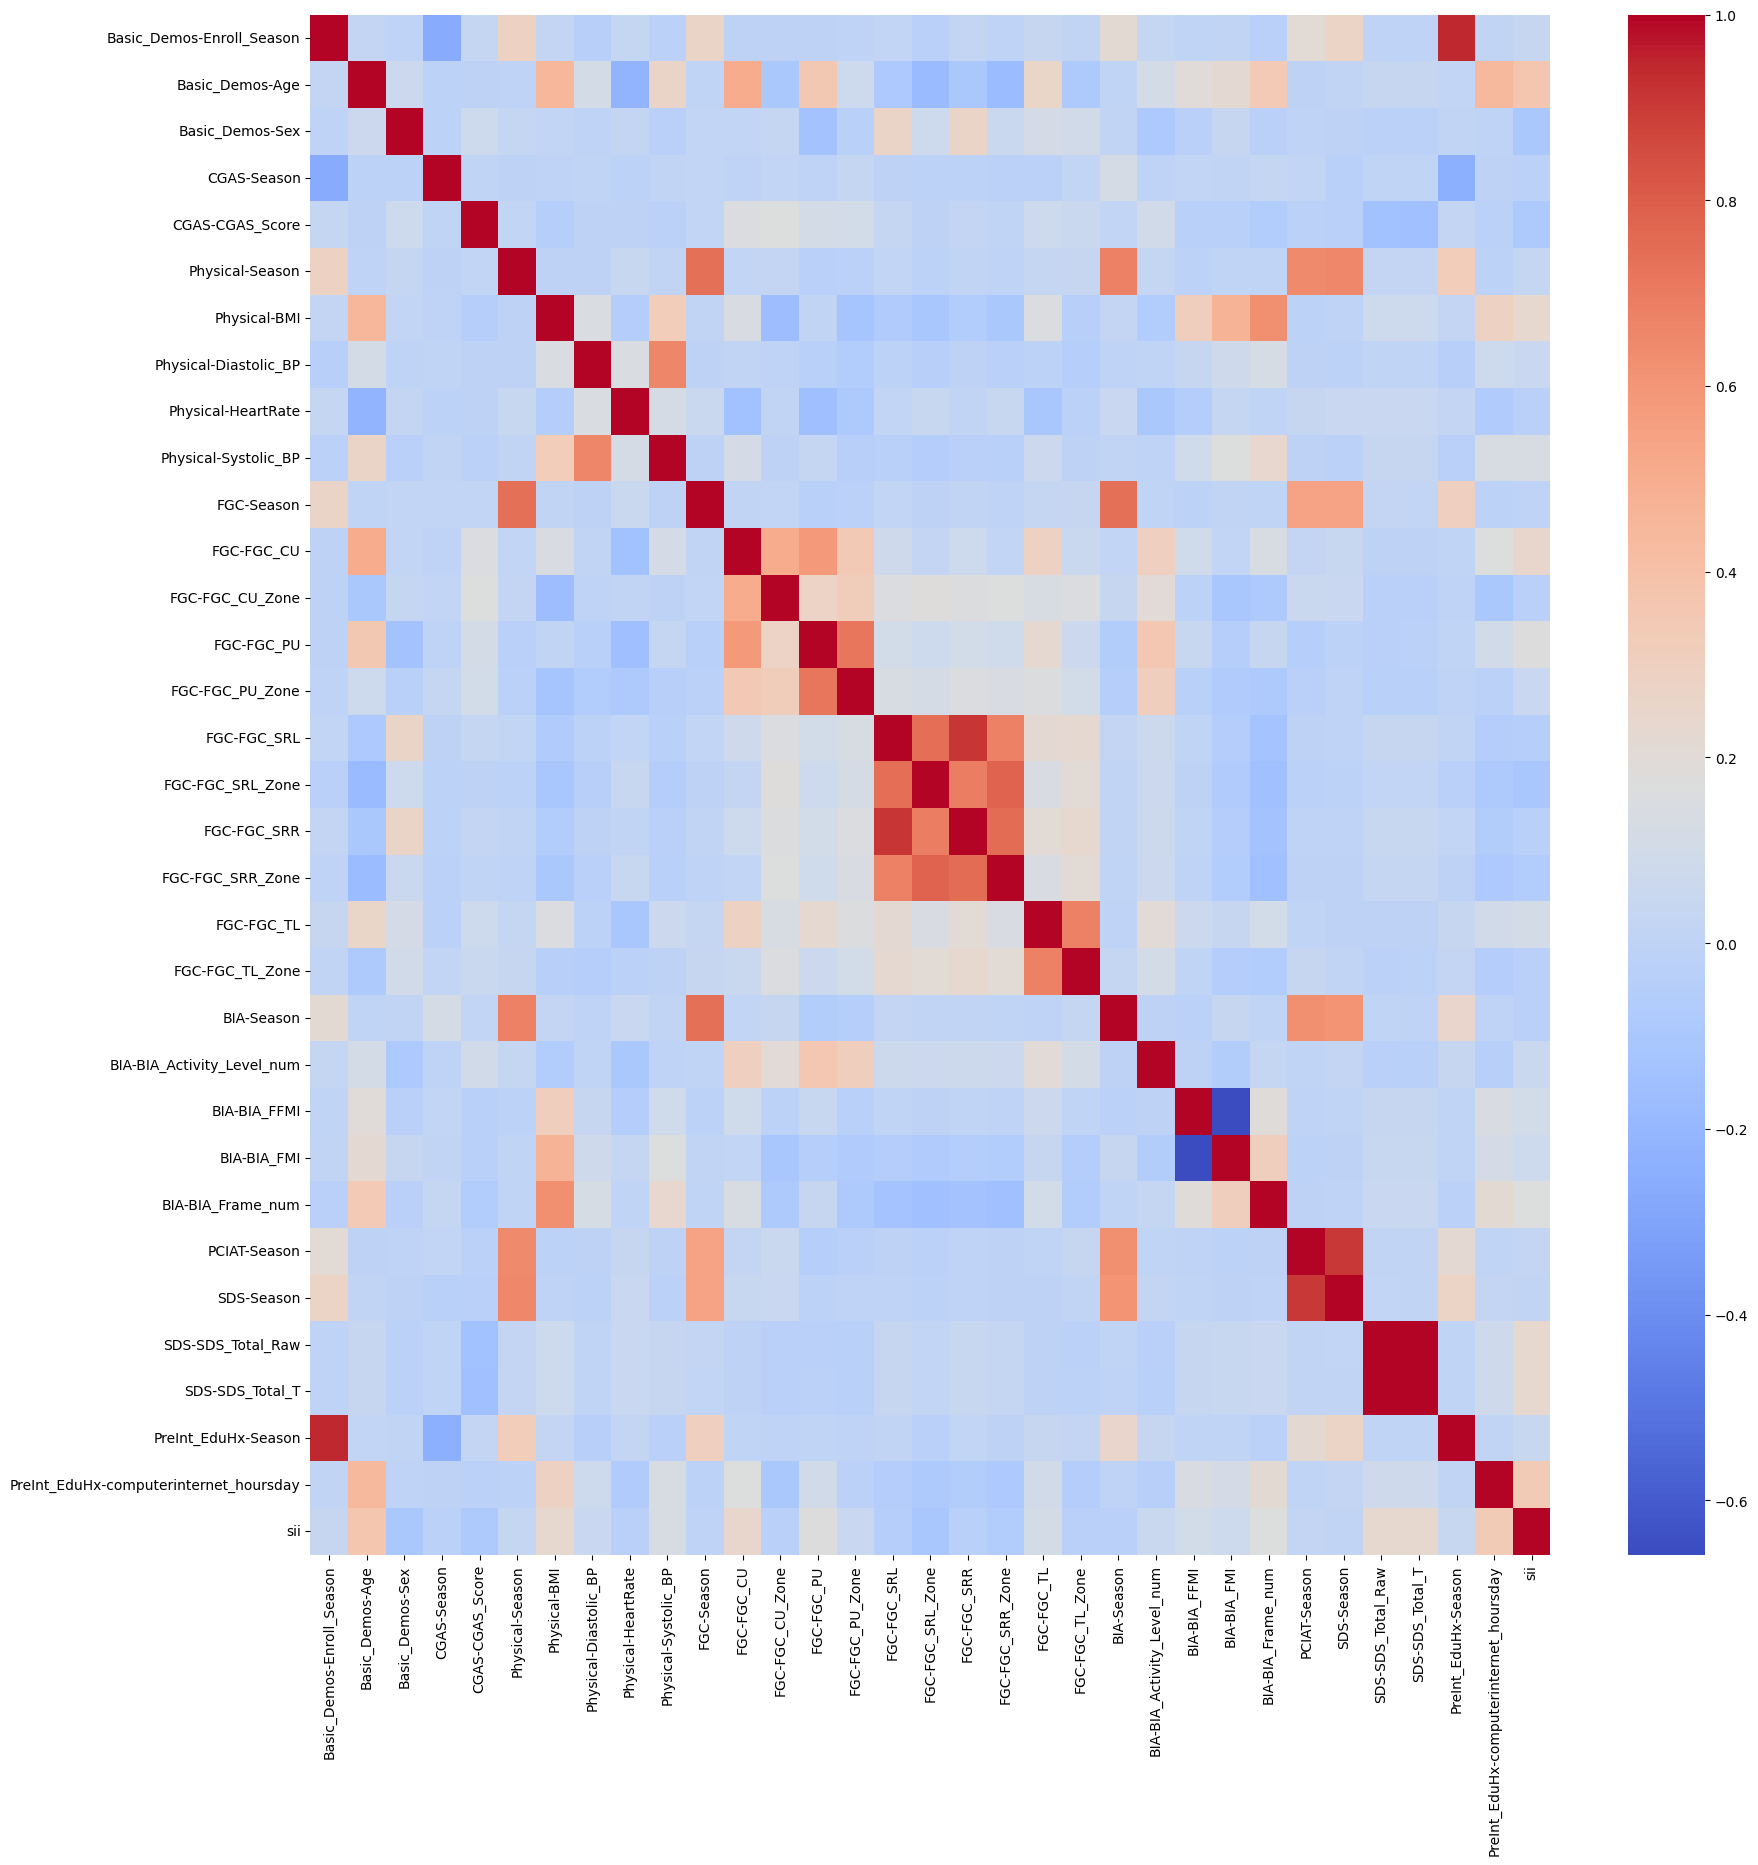

In [299]:
temp = train_df.copy()
temp.drop(['id'], axis=1, inplace=True)
correlation_matrix = temp.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

In [300]:
fgc_sr_columns = ['FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone']
temp.drop(columns=['SDS-SDS_Total_Raw'] + fgc_sr_columns, inplace=True)

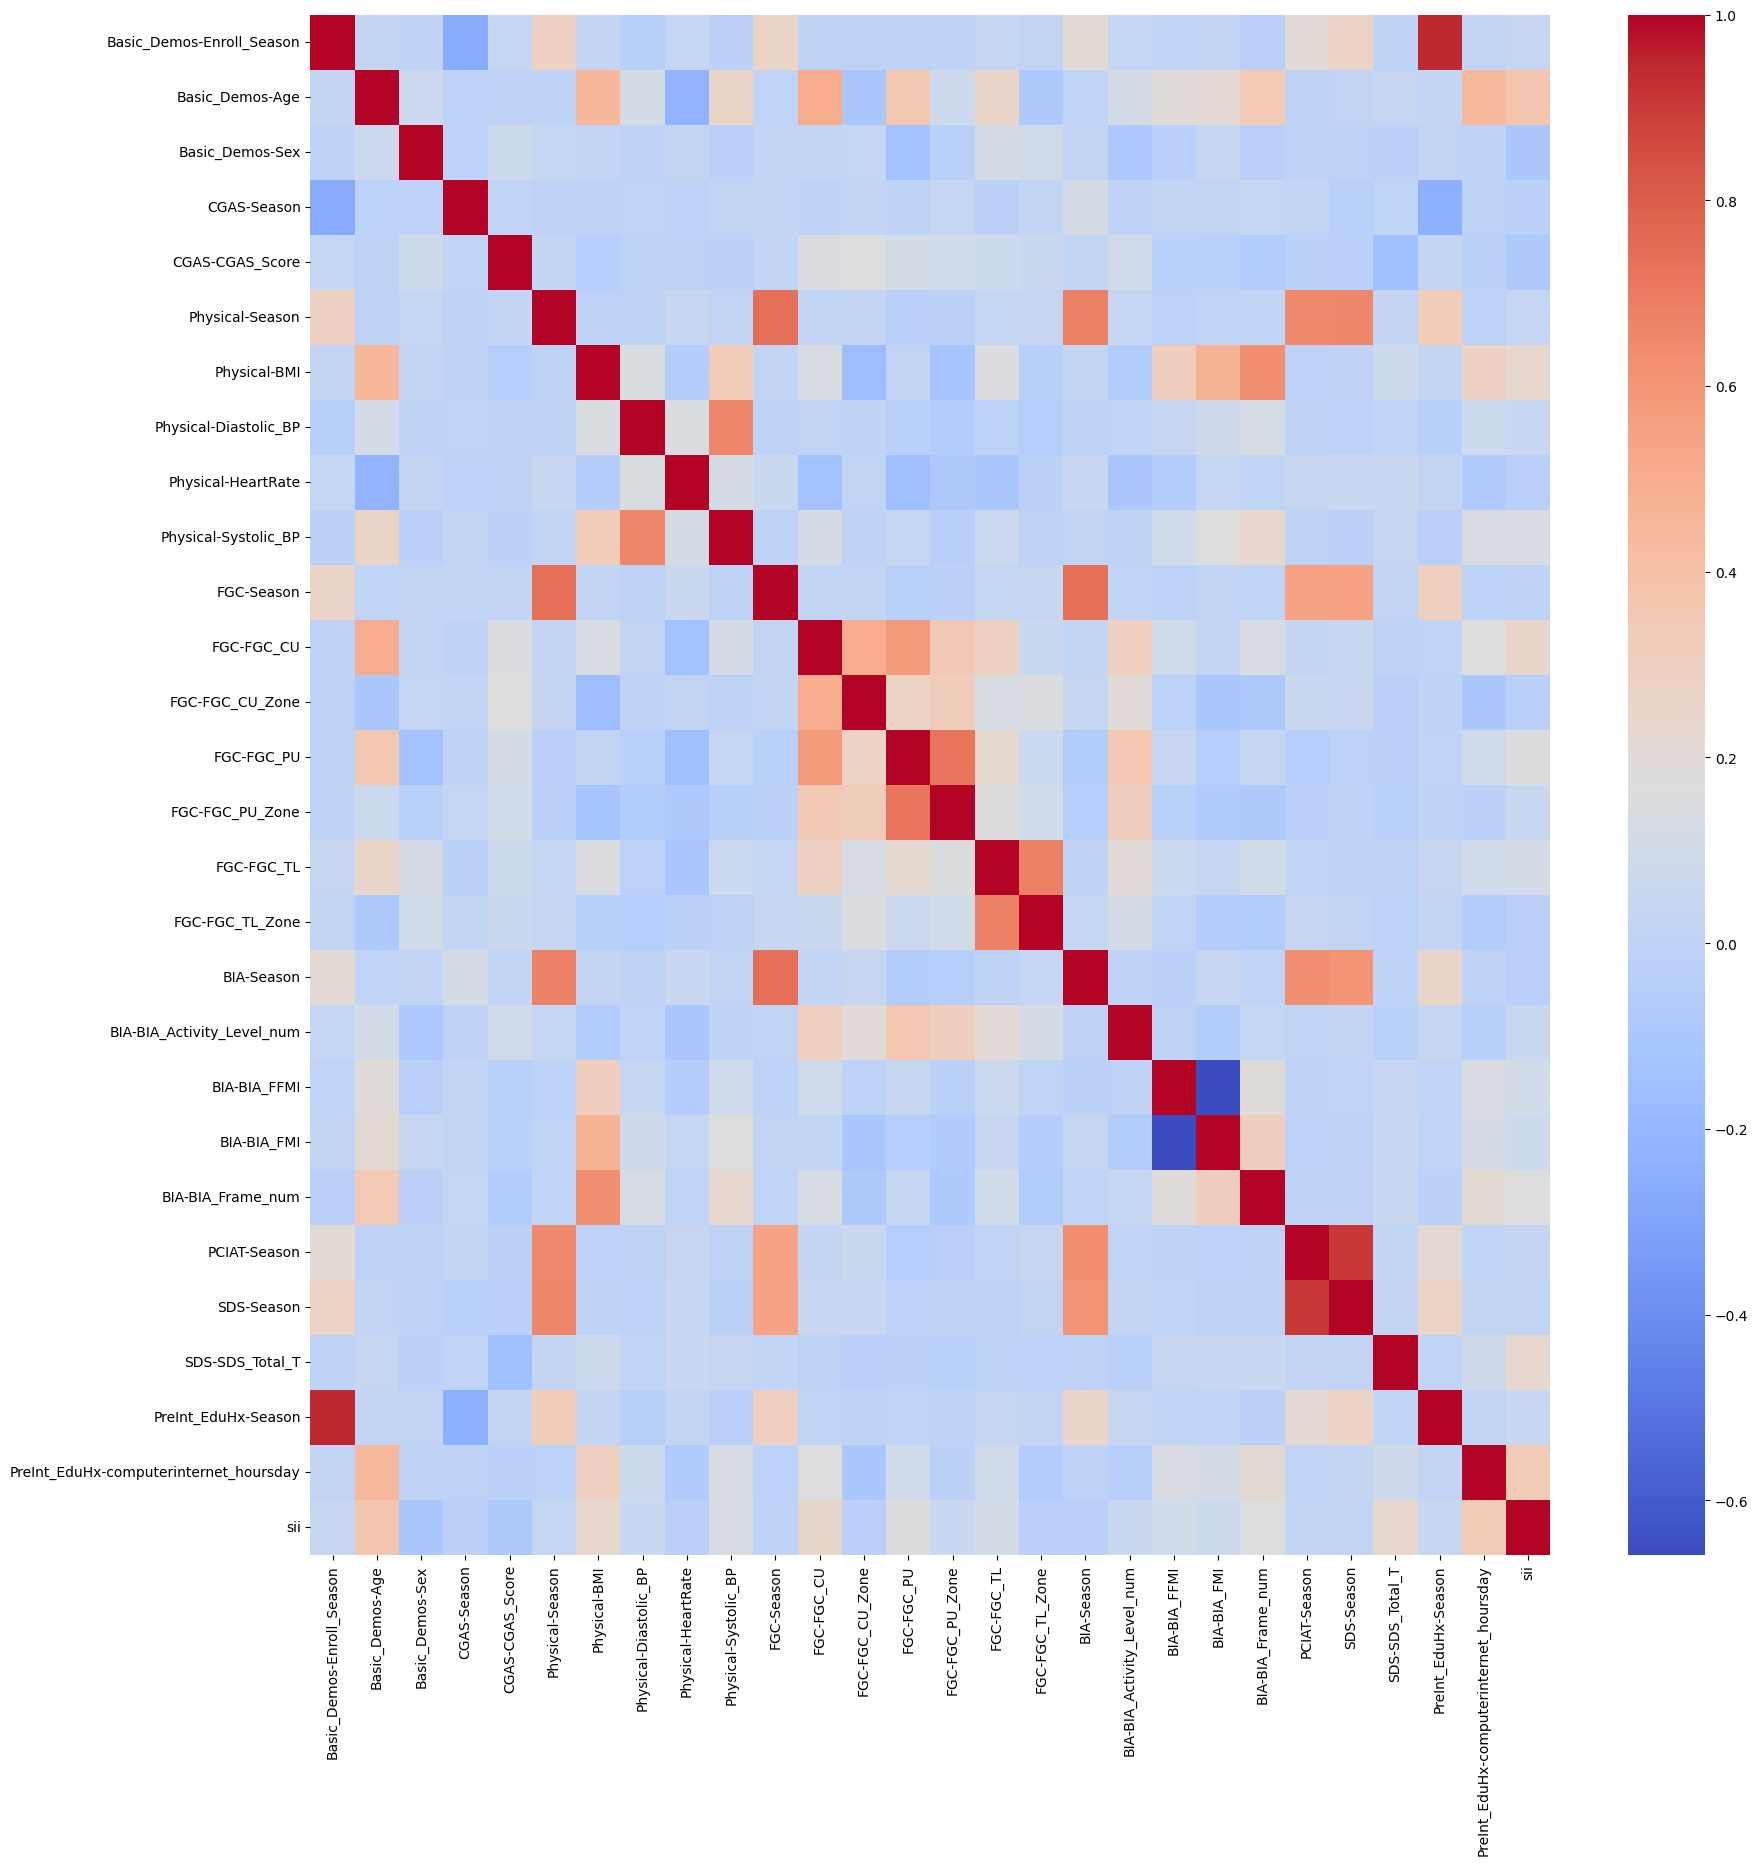

In [301]:
correlation_matrix = temp.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

In [302]:
# Calculate the correlation of each column with the 'sii' column
correlation_with_sii = temp.corr()['sii']

# Get the columns that have a correlation of less than 0 with 'sii'
columns_to_drop = correlation_with_sii[correlation_with_sii < 0].index

# Drop the columns from the dataframe
temp.drop(columns=columns_to_drop, inplace=True)

# Display the remaining columns
temp.columns

Index(['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Physical-Season',
       'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-Systolic_BP',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
       'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_FFMI',
       'BIA-BIA_FMI', 'BIA-BIA_Frame_num', 'PCIAT-Season', 'SDS-Season',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday', 'sii'],
      dtype='object')

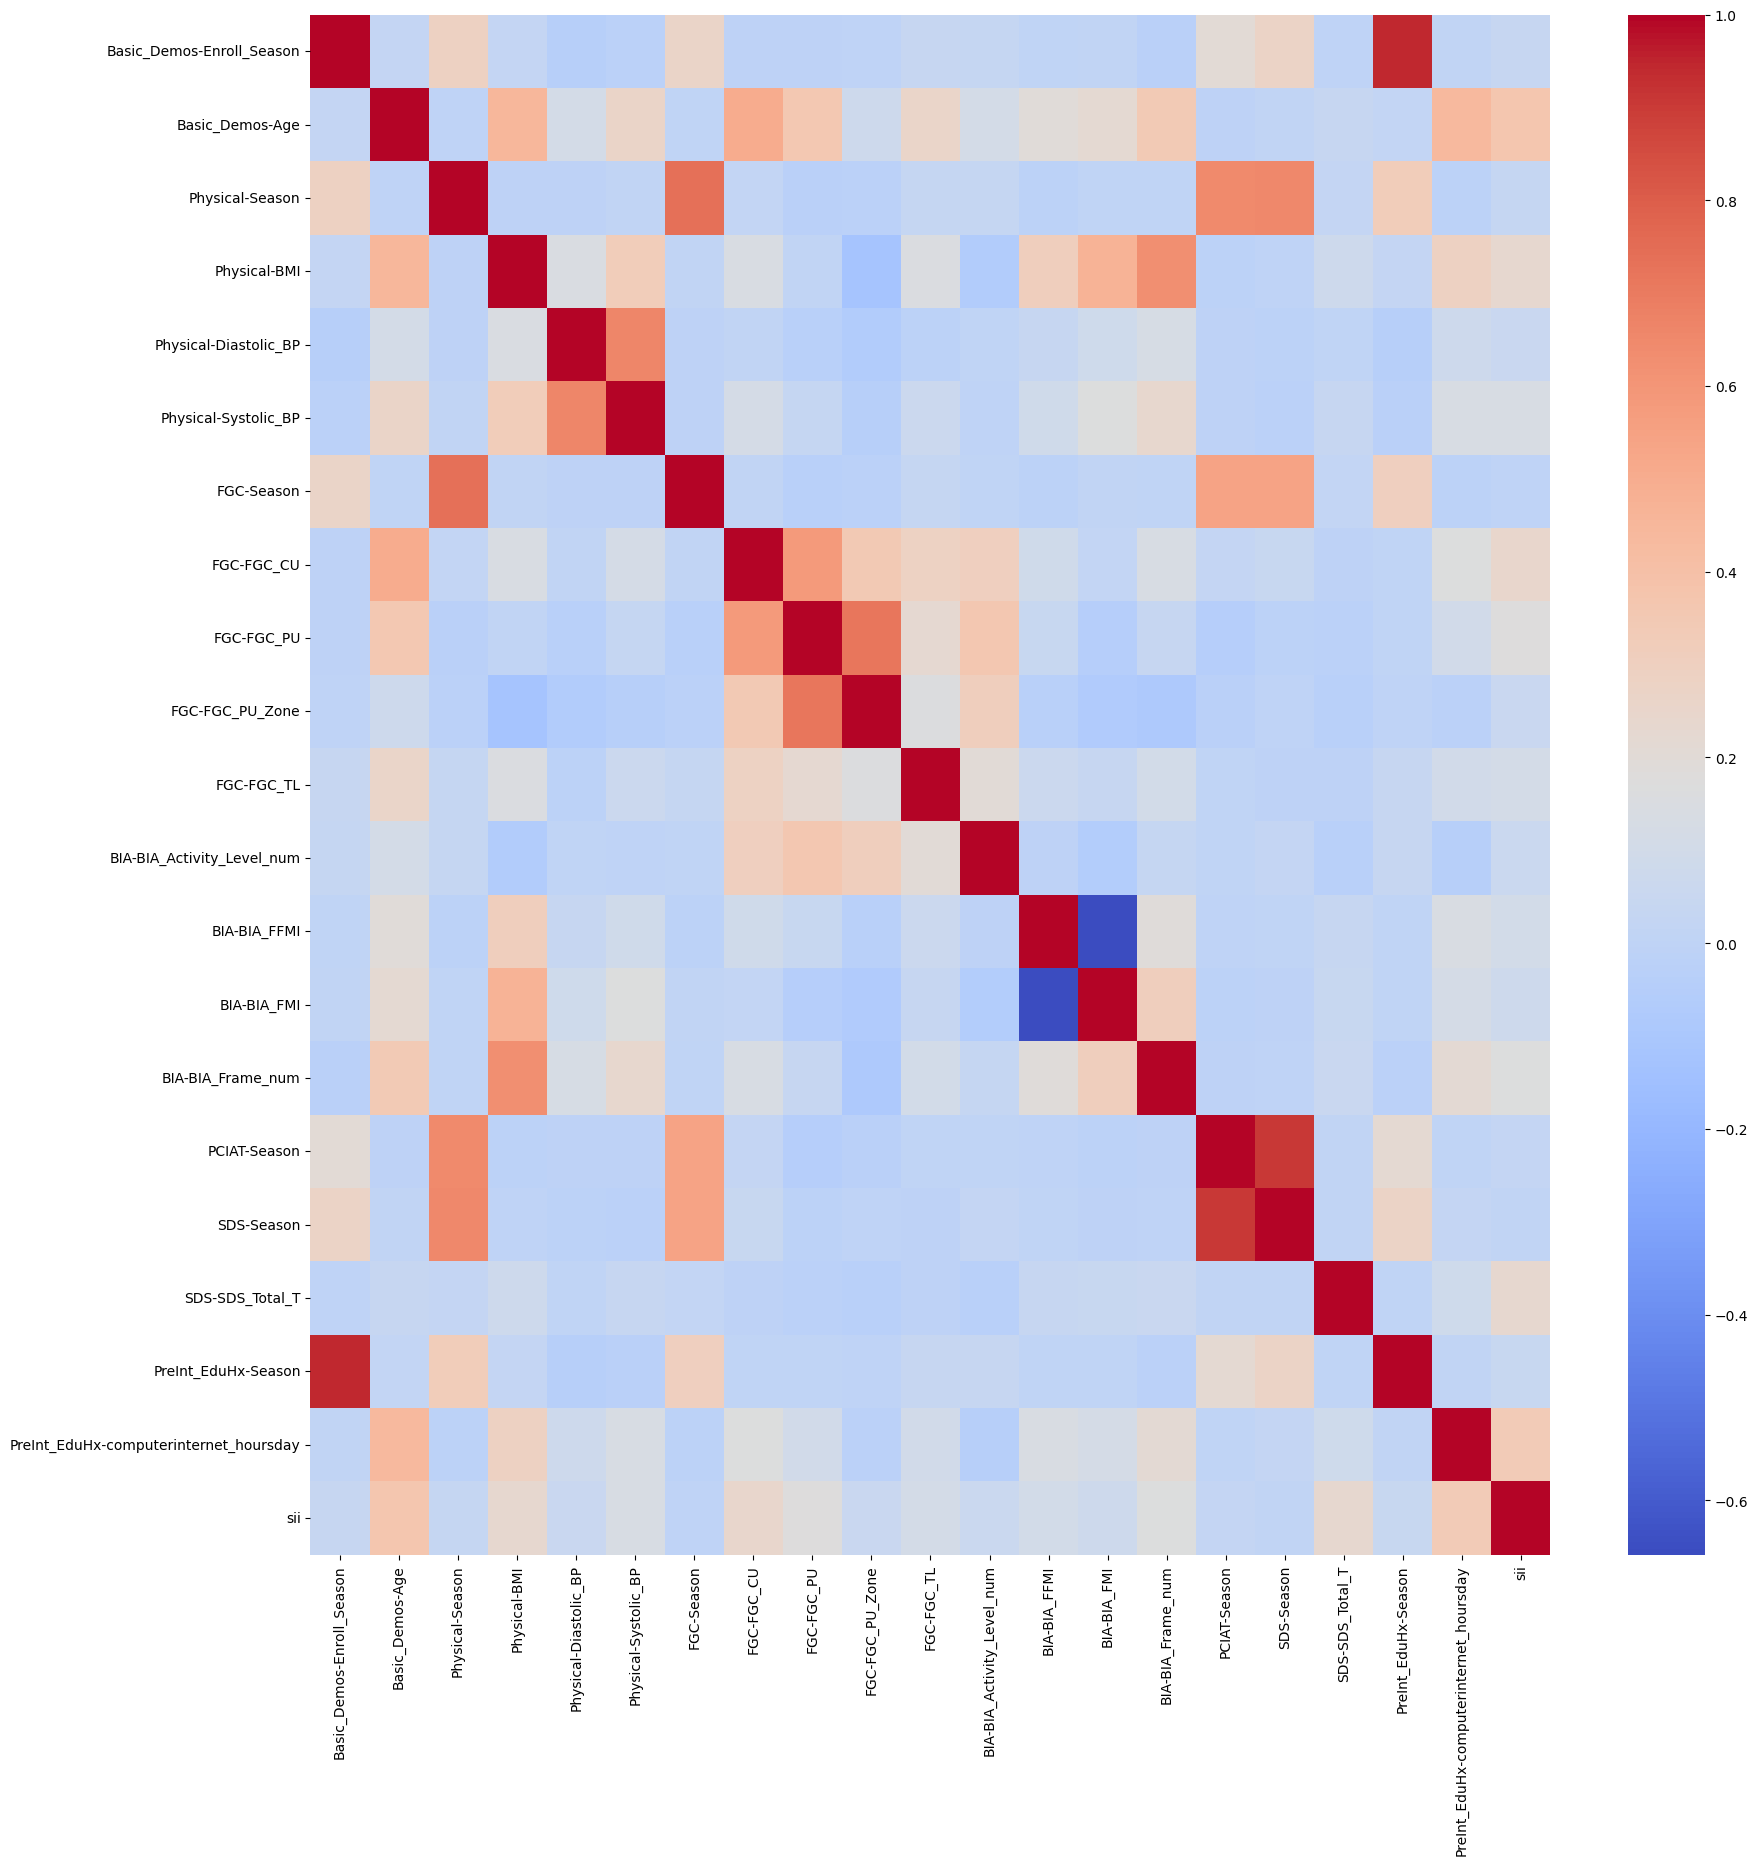

In [303]:
correlation_matrix = temp.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

In [304]:
train_df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
       'BIA-BIA_Frame_num', 'PCIAT-Season', 'SDS-Season', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday', 'sii'],
      dtype='object')

In [305]:
basic_demos_df = train_df.filter(regex='^Basic_Demos')
cgas_df = train_df.filter(regex='^CGAS')
physical_df = train_df.filter(regex='^Physical')
fitness_df = train_df.filter(regex='^Fitness')
fgc_df = train_df.filter(regex='^FGC')
bia_df = train_df.filter(regex='^BIA')
paq_df = train_df.filter(regex='^PAQ')
pciat_df = train_df.filter(regex='^PCIA')
sds_df = train_df.filter(regex='^SDS')
preint_df = train_df.filter(regex='^PreInt')

In [306]:
dataframes = {
    'basic_demos_df': basic_demos_df,
    'cgas_df': cgas_df,
    'physical_df': physical_df,
    'fitness_df': fitness_df,
    'fgc_df': fgc_df,
    'bia_df': bia_df,
    'paq_df': paq_df,
    'pciat_df': pciat_df,
    'sds_df': sds_df,
    'preint_df': preint_df
}

null_percentages = {name: (df.isnull().sum() / len(df) * 100) for name, df in dataframes.items()}
for name, null_percentage in null_percentages.items():
    print(f"Null percentages for {name}:")
    display(null_percentage)

Null percentages for basic_demos_df:


Basic_Demos-Enroll_Season    0.0
Basic_Demos-Age              0.0
Basic_Demos-Sex              0.0
dtype: float64

Null percentages for cgas_df:


CGAS-Season        35.479798
CGAS-CGAS_Score    38.863636
dtype: float64

Null percentages for physical_df:


Physical-Season          16.414141
Physical-BMI              0.000000
Physical-Diastolic_BP    25.404040
Physical-HeartRate       25.075758
Physical-Systolic_BP     25.404040
dtype: float64

Null percentages for fitness_df:


Series([], dtype: float64)

Null percentages for fgc_df:


FGC-Season          15.505051
FGC-FGC_CU          41.363636
FGC-FGC_CU_Zone     42.373737
FGC-FGC_PU          41.666667
FGC-FGC_PU_Zone     42.651515
FGC-FGC_SRL         41.792929
FGC-FGC_SRL_Zone    42.752525
FGC-FGC_SRR         41.742424
FGC-FGC_SRR_Zone    42.702020
FGC-FGC_TL          41.313131
FGC-FGC_TL_Zone     42.297980
dtype: float64

Null percentages for bia_df:


BIA-Season                    45.833333
BIA-BIA_Activity_Level_num    49.722222
BIA-BIA_FFMI                  49.722222
BIA-BIA_FMI                   49.722222
BIA-BIA_Frame_num             49.722222
dtype: float64

Null percentages for paq_df:


Series([], dtype: float64)

Null percentages for pciat_df:


PCIAT-Season    30.909091
dtype: float64

Null percentages for sds_df:


SDS-Season           33.888889
SDS-SDS_Total_Raw    34.116162
SDS-SDS_Total_T      34.191919
dtype: float64

Null percentages for preint_df:


PreInt_EduHx-Season                       10.606061
PreInt_EduHx-computerinternet_hoursday    16.641414
dtype: float64

We will look more into the data if there are some patterns that we can see and to possibly use to fill values

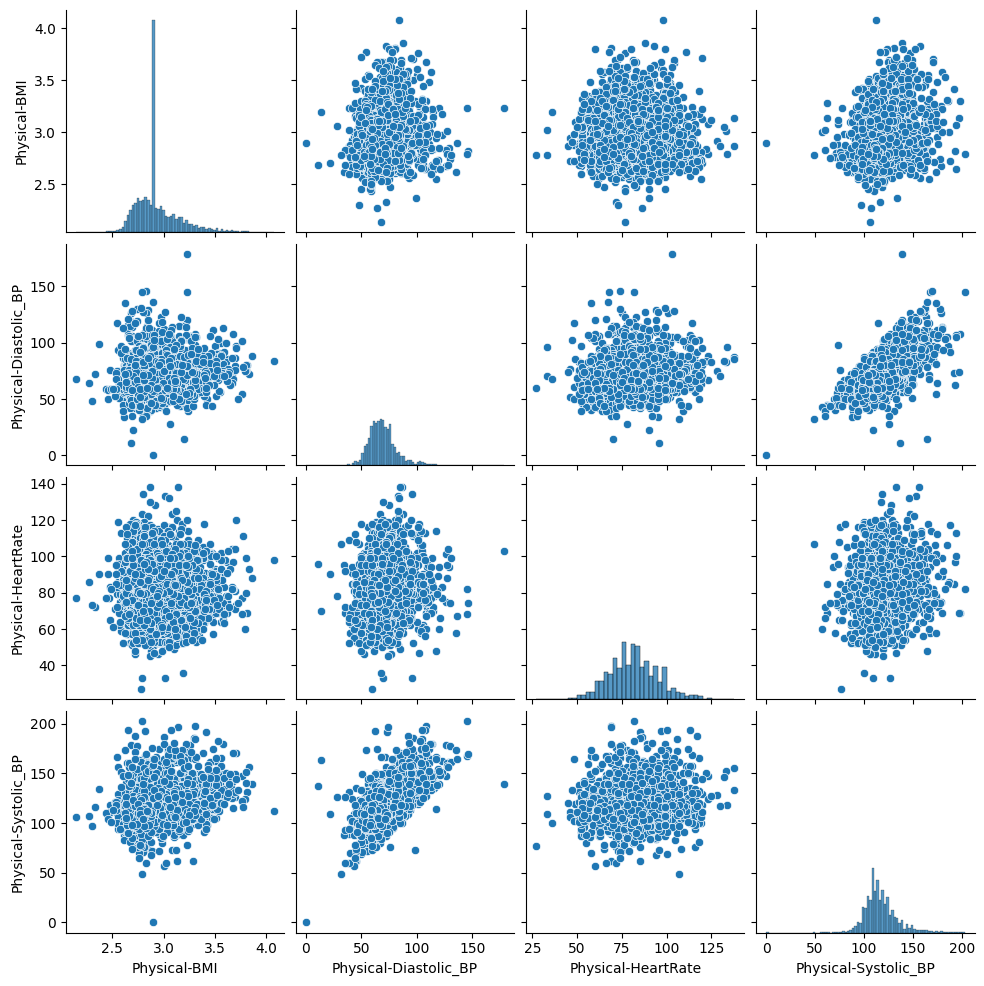

KeyError: "['Fitness_Endurance-Season'] not found in axis"

In [307]:
sns.pairplot(physical_df.drop(columns=['Physical-Season']))
plt.show()
sns.pairplot(fitness_df.drop(columns=['Fitness_Endurance-Season']))
plt.show()
sns.pairplot(fgc_df.drop(columns=['FGC-Season']))
plt.show()
sns.pairplot(bia_df.drop(columns=['BIA-Season']))
plt.show()
sns.pairplot(paq_df)
plt.show()
sns.pairplot(sds_df)
plt.show()
sns.pairplot(preint_df)
plt.show()

### Height is not used but this can be used as a template

In [ ]:
get_null_percentage('Physical-Height', train_df)

'Null percentage for Physical-Height: 23.56'

In [ ]:
train_df_copy = train_df.copy()
train_df_copy = train_df_copy.dropna(subset=['Physical-Height'])

poly = PolynomialFeatures(degree=3, include_bias=False)
height_model = make_pipeline(poly, LinearRegression())

X = train_df_copy[['Basic_Demos-Age']]
y = train_df_copy['Physical-Height']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

height_model.fit(X_train, y_train)

score = height_model.score(X_test, y_test)
print(f'Score: {score}')

Score: 0.8291284390356732


In [ ]:
for index, row in train_df.iterrows():
    if pd.isnull(row['Physical-Height']):
        predicted_height = height_model.predict([[row['Basic_Demos-Age']]])[0]
        train_df.at[index, 'Physical-Height'] = predicted_height

display(train_df)

/Users/asilins/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/asilins/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/asilins/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/asilins/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/asilins/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/asilins/anaconda3/

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,2,5,0,3.0,51.0,2.0,16.877316,46.000000,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,2.0,3.0,2.0
1,000fd460,1,9,0,NaN,NaN,2.0,14.035590,48.000000,46.0,...,0.0,0.0,0.0,0.0,2.0,46.0,64.0,1.0,0.0,0.0
2,00105258,1,10,1,2.0,71.0,2.0,16.648696,56.500000,75.6,...,2.0,1.0,1.0,28.0,2.0,38.0,54.0,1.0,2.0,0.0
3,00115b9f,3,9,0,2.0,71.0,1.0,18.292347,56.000000,81.6,...,3.0,4.0,1.0,44.0,1.0,31.0,45.0,3.0,0.0,1.0
4,0016bb22,0,18,1,1.0,NaN,NaN,NaN,67.782975,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,2,13,0,0.0,60.0,2.0,16.362460,59.500000,82.4,...,1.0,1.0,0.0,32.0,3.0,35.0,50.0,2.0,1.0,1.0
3956,ffa9794a,3,10,0,NaN,NaN,0.0,18.764678,53.500000,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN
3957,ffcd4dbd,2,11,0,0.0,68.0,3.0,21.441500,60.000000,109.8,...,1.0,0.0,1.0,31.0,3.0,56.0,77.0,2.0,0.0,1.0
3958,ffed1dd5,0,13,0,0.0,70.0,3.0,12.235895,70.700000,87.0,...,1.0,1.0,1.0,19.0,0.0,33.0,47.0,0.0,1.0,0.0


Seeing that the result of adding the values does not give accurate results using a model to predict the values won't be useful. What also plays in the accuracy is that the plot looks more as a cone shaped.

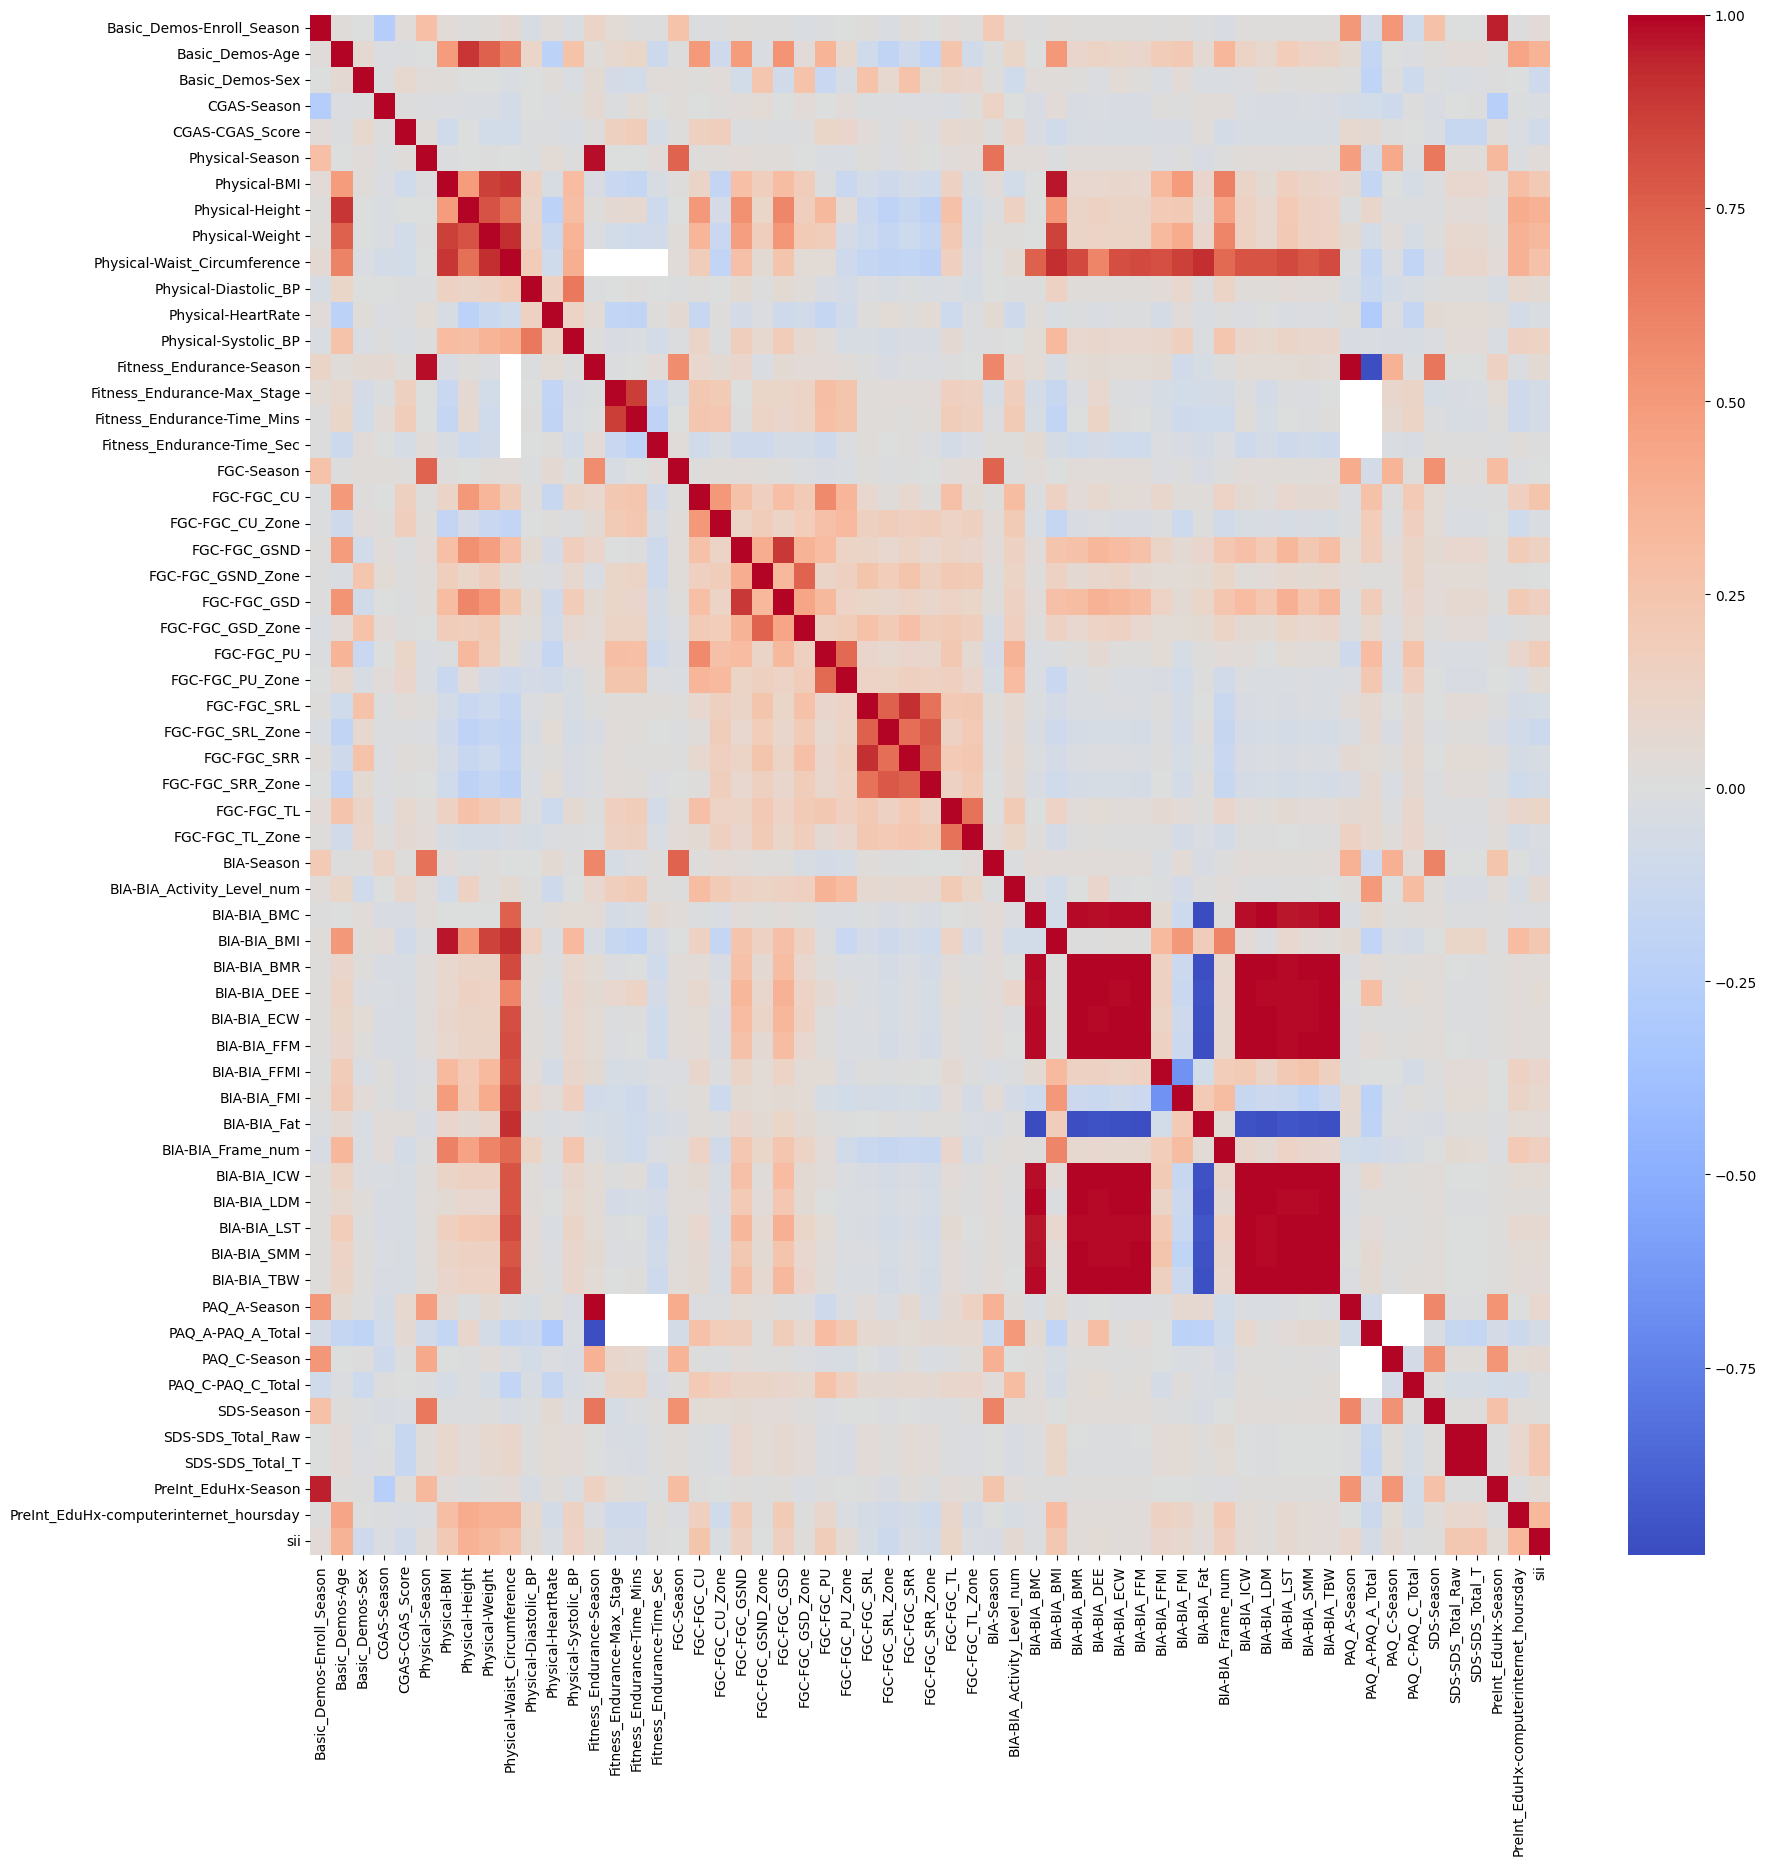

In [ ]:
temp = train_df.copy()
temp.drop(['id'], axis=1, inplace=True)
correlation_matrix = temp.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()